## Before run

```
# create a python virtualenv for separating the dependencies
virtualenv virtualenv

# enter the virtualenv
source virtualenv/bin/activate

# install the dependencies
pip install -r requirements.txt
```

Please run the first frame.

In [1]:
import os

DATA_FOLDER = './data'

log = print
if not os.path.exists(DATA_FOLDER + '/evaluation'):
    os.mkdir(DATA_FOLDER + '/evaluation')

if not os.path.exists(f'{DATA_FOLDER}/Info_UserData.csv'):
    import kaggle

    kaggle.api.authenticate()
    log('Download dataset...')
    kaggle.api.dataset_download_files('junyiacademy/learning-activity-public-dataset-by-junyi-academy',
                                      path=DATA_FOLDER, unzip=True)
    log('Dataset downloaded.')
else:
    log("The dataset is present on the machine.")

Download dataset...
Dataset downloaded.


In [3]:
print('Files in the dataset: ')
for dirname, _, filenames in os.walk(DATA_FOLDER):
    for filename in filenames:
        print(os.path.join(filename))

Files in the dataset: 
Info_Content.csv
Info_UserData.csv
Log_Problem.csv


Loading data...
Feature extraction...
Preprocessing...


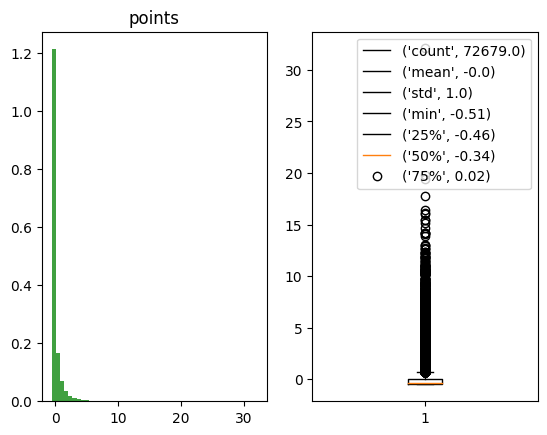

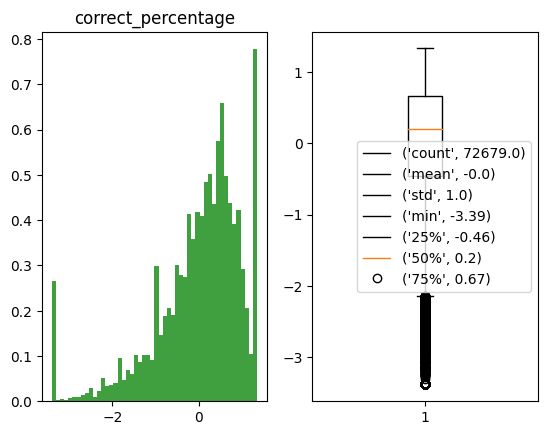

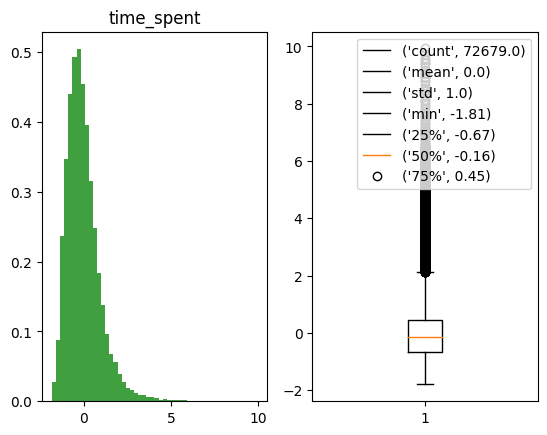

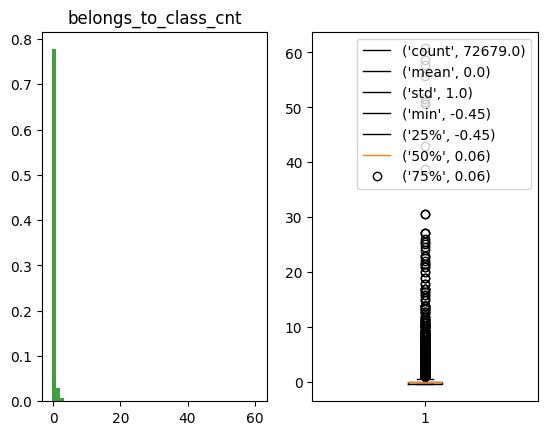

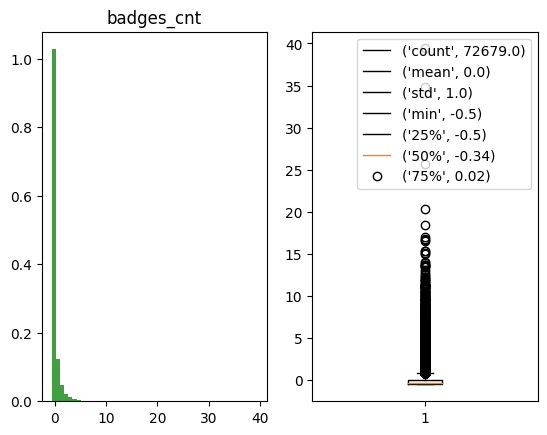

In [4]:
import pandas as pd
import numpy as np
from data_preprocessing import extract_additional_user_features, preprocess_df
from feature_categorization import U_features


def load_data_raw():
    df_u = pd.read_csv(f'{DATA_FOLDER}/Info_UserData.csv')
    df_pr = pd.read_csv(f'{DATA_FOLDER}/Log_Problem.csv')
    df_ex = pd.read_csv(f'{DATA_FOLDER}/Info_Content.csv')
    return df_u, df_pr, df_ex


def remove_problems_with_total_time_outliers(df_pr):
    limit = np.quantile(df_pr['total_sec_taken'], 0.98)
    new_df_pr = df_pr[df_pr['total_sec_taken'] < limit]
    return new_df_pr

# if `log` is undefined then please run the first frame
log("Loading data...")
df_u, df_pr, df_c = load_data_raw()
df_pr = remove_problems_with_total_time_outliers(df_pr)

log("Feature extraction...")
X = extract_additional_user_features(df_u, df_pr, df_c)

log("Preprocessing...")
user_features = U_features()
X: pd.DataFrame = preprocess_df(df=X, o_features=user_features)

In [5]:
from cure import *


def split_users_by_grade(df):
    split1 = df[df["user_grade"] < 4]
    split2 = df[df["user_grade"] == 5]
    split3 = df[df["user_grade"] == 6]
    split4 = df[df["user_grade"] == 7]
    split5 = df[df["user_grade"] > 7]
    return [split1, split2, split3, split4, split5], ["split1", "split2", "split3", "split4", "split5"]


def cure_clustering(df: pd.DataFrame):
    data = df.drop(columns=["uuid"]).to_numpy()
    cure_repres = cure_representatives(data)
    cluster_labels = cure_classify(data, cure_repres)
    n_clusters = cluster_labels.max() + 1
    partition = lambda k: data[cluster_labels == k]
    similarities = [pairwise_distances(partition(k)) for k in range(n_clusters)]
    sim_users = [df["uuid"][cluster_labels == k] for k in range(n_clusters)]
    return cluster_labels, similarities, sim_users


USE_USER_USER_SIMILARITY = True
all_split_labels = []
all_split_similarities = []
all_split_sim_users = []

log("Splitting users...")
dfs, labels = split_users_by_grade(X)
del X

log('Cluster each instance of the split...')
for df, label in zip(dfs, labels):
    log("Getting clusters for {} users...".format(label))
    cluster_labels, similarities, sim_users = cure_clustering(df)
    all_split_labels.append(cluster_labels)
    all_split_similarities.append(similarities)
    all_split_sim_users.append(sim_users)

Splitting users...
Cluster each instance of the split...
Getting clusters for split1 users...
Getting clusters for split2 users...
Getting clusters for split3 users...
Getting clusters for split4 users...
Getting clusters for split5 users...


In [7]:
from sklearn.metrics import davies_bouldin_score


def evaluate_clusterings(combined):
    for df, split, labels in combined:
        df = df.drop(columns=["uuid", "first_login_date_TW"])
        data = df.to_numpy()
        log(f"Split: {split} | Davies-Bouldin score: ", davies_bouldin_score(data, labels))
        centroids = [np.average(data[labels == k], axis=0) for k in range(labels.max() + 1)]

        def interesting_columns(x: np.ndarray):
            return list(filter(lambda pair: pair[1] > 0.07, zip(df.columns, x)))

        c0 = centroids[0]
        log(f"Centroid differences (for {len(centroids)} clusters):")
        for i in range(1, min(3, len(centroids))):
            c1 = centroids[i]
            cdiff = interesting_columns(c0 - c1)[:3]
            log(cdiff)
        log('---')

log('Evaluate clusters in each split')
log('---')
evaluate_clusterings(zip(dfs, labels, all_split_labels))

Evaluate clusters in each split
---
Split: split1 | Davies-Bouldin score:  20.268926931091183
Centroid differences (for 6 clusters):
[('problems_attempted', 94.23059578820843), ('max_level', 0.428081396660126), ('user_city_tc', 0.09867879019450979)]
[('user_city_tc', 0.12873371096047295)]
---
Split: split2 | Davies-Bouldin score:  9.972293127072376
Centroid differences (for 5 clusters):
[('has_teacher_cnt', 0.2625599255736243), ('has_student_cnt', 0.20002531509380825), ('problems_attempted', 326.1009645050741)]
[('has_teacher_cnt', 0.2655196760111196), ('has_student_cnt', 0.1820106558328582), ('problems_attempted', 295.76907680820125)]
---
Split: split3 | Davies-Bouldin score:  117.7730148550686
Centroid differences (for 9 clusters):
[('gender_unspecified', 0.21094107551487418), ('user_city_ty', 0.13782894736842108)]
[('gender_unspecified', 0.13500284422852227), ('user_city_ty', 0.15894048643994835), ('correct_percentage', 0.1176622353347825)]
---
Split: split4 | Davies-Bouldin score: 

In [ ]:
from recommender_system import *


def bind_labels_and_uuid(cluster_labels, sim_users):
    cluster_partitions = [cluster_labels[cluster_labels == i] for i in range(cluster_labels.max() + 1)]
    clusters = pd.DataFrame([np.hstack(cluster_partitions), np.hstack(sim_users)]).T
    clusters.columns = ["labels", "uuid"]
    return clusters


log("Binding clusters labels and uuids for all splits")
all_segment_clusters = [bind_labels_and_uuid(c_labels, s_users) for (c_labels, s_users) in
                        zip(all_split_labels, all_split_sim_users)]


def run_and_evaluate_recommender_system(clusters, df_pr, df_u, user_user_similarities, cluster_id=0,
                                        use_user_user_similarity=False):
    M, M_test, U1_ids, P1_ids = generate_utility_matrix_for_one_cluster(clusters=clusters, df_u_full=df_u,
                                                                        df_pr_full=df_pr, cluster_id=cluster_id)

    cluster_user_user_similarity = user_user_similarities[cluster_id]

    difficulties_for_all_users, errors_all = get_psedu_problem_difficulties(M, M_test, cluster_user_user_similarity,
                                                                            use_user_user_similarity)
    errors = [item[0] for sublist in errors_all for item in sublist if len(item) > 0]
    mean_abs_error = np.mean(errors)
    recommendation_difficulty_for_all_users, recommendation_idx_all = get_recommendation(difficulties_for_all_users)
    num_users = clusters.loc[clusters['labels'] == cluster_id].shape[0]
    print("Mean absolute error of difficulty was {} for cluster {} with {} users and use_similarrity={}".format(
        mean_abs_error, cluster_id, num_users, str(use_user_user_similarity)))
    return mean_abs_error, errors, recommendation_difficulty_for_all_users, recommendation_idx_all, np.mean(
        difficulties_for_all_users[difficulties_for_all_users > 0])


# Run all splits, and all clusters
mean_errors = []
for split_idx, clusters_ in enumerate(all_segment_clusters):
    df_u_split = dfs[split_idx]
    df_p_split = df_pr.loc[df_pr['uuid'].isin(df_u_split['uuid'])]
    similarities_ = all_split_similarities[split_idx]
    for cluster_idx in tqdm(range(len(similarities_)), desc="running cluster"):
        mean_abs_error, errors, recommendation_difficulty_for_all_users, recommendation_idx_all, mean_difficulty = run_and_evaluate_recommender_system(
            clusters_, df_p_split, df_u_split, similarities_, cluster_idx, USE_USER_USER_SIMILARITY)
        mean_errors.append(mean_abs_error)
        with open(f'{DATA_FOLDER}/evaluation/eval_mean_errors_5splits.txt', 'a') as f:
            f.write(
                "split_id: {},split_size: {}, cluster_id: {},cluster_u_size {}, n_errors: {}, mean_error: {}, mean_difficulty: {}, mean_recommendation_difficulty: {}\n".format(
                    split_idx, df_u_split.shape[0], cluster_idx, similarities_[cluster_idx].shape[0],
                    len(errors), np.round(mean_abs_error, 5), np.round(mean_difficulty, 5),
                    np.round(np.mean(recommendation_difficulty_for_all_users), 5)))
        with open(f'{DATA_FOLDER}/evaluation/eval_error_5splitss.txt', 'a') as f:
            f.write("split_id: {}, cluster_id: {}, errors {}\n".format(split_idx, cluster_idx, errors))
print("Mean absolute errors for the different splits {}".format(mean_errors))